# INSEE income data - User validation 

In [83]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import importlib
# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *

### N-grams + frequency analysis

In [ ]:
# # Load the dimension data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
bios = pd.read_csv(path+file, index_col=0)

#Sort the df from high to low according to the first dimenion
bios = bios.sort_values(by='0', ascending=False)
#bios['follower_id'].nunique() #115079

#### Obtain the most frequent n-grams in bios

From bios:

In [ ]:
importlib.reload(utils2)
# Usage:
all_descriptions = ' '.join(bios['description_cleantext'])
ngram_freq = utils2.get_ngram_freq(all_descriptions,n=1)


# Get the most common bigrams
#most_common_unigrams = ngram_freq.most_common(4000)

#Write the ngrams to csv
# importlib.reload(utils2)
# utils2.write_ngrams_to_csv(most_common_unigrams, 'unigrams.csv')
# utils2.write_ngrams_to_csv(most_common_bigrams, 'bigrams.csv')
# utils2.write_ngrams_to_csv(most_common_trigrams, 'trigrams.csv')
# utils2.write_ngrams_to_csv(unigrams_last1000, 'uni_last1000.csv')

### Data soure 1: Filter bios based on ngrams from bios

- Here, I am filtering the user bios by looking for overlapping ngrams. The ngrams I use here stem from people's bios, so identifying the common ways of referring to a job title. 
- This is the ngram matching approach that yields the most amount of users, since it reflects people's everyday language. 
- Eventually, the final df from this part needs to be annotated, deleting poorly identified bios. 

In [281]:
#Load the file containing all relevant ngrams
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'keywords_INSEE.csv'
job_titles = pd.read_csv(path+file, header=0)

In [282]:
#Preprocessing of the key word file

#rename columns
job_titles = job_titles.rename(columns={'n_gram': 'key_word', 'PCS_ESE_code': 'PCS_ESE'})

#Sort job titles alphabetically and drop unnecessary cols
job_titles = job_titles.sort_values('key_word')
job_titles = job_titles.drop('ngram', axis=1)
job_titles = job_titles.drop('count', axis=1)

#dropping the ocs category just for now. might add it later - if income validation is not enough
job_titles = job_titles.drop('pcs_category_numbers', axis=1)
job_titles = job_titles.drop('pcs_category_name', axis=1)

#Syarting with 547 rows (key words of different token size)

#Reformat NA cells and drop rows with no CS_ESE code 
job_titles['PCS_ESE_name'] = job_titles['PCS_ESE_name'].replace('Na', np.nan)
job_titles['PCS_ESE'] = job_titles['PCS_ESE'].replace('Na', np.nan)

job_titles = job_titles.dropna(subset=['PCS_ESE']) #Now we have 226 key words left. We started with 547 key words. 321 could not be matched with INSEE data. 


#Remove newline characters in the 'PCS_ESE_name' column
job_titles['PCS_ESE'] = job_titles['PCS_ESE'].replace('\n', ' ', regex=True)
job_titles['PCS_ESE'] = job_titles['PCS_ESE'].str.strip()


job_titles['PCS_ESE_name'] = job_titles['PCS_ESE_name'].replace('\n', ' ', regex=True)
job_titles['PCS_ESE_name'] = job_titles['PCS_ESE_name'].str.strip()


In [283]:
#Load the merged income data

#income
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'INSEE_merged.csv'
income = pd.read_csv(path+file, sep=",")

#make the codes lower case, to match between data sets
income = income.drop(income.columns[0], axis=1)
income['PCS_ESE'] = income['PCS_ESE'].str.lower()
income = income.sort_values('Salaire moyen en EQTP')

In [284]:
#Get the user bios - that later wil get added income
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
bios = pd.read_csv(path+file, index_col=0)

#Sort the df according to the first dimenion
bios = bios.sort_values(by='0', ascending=False)

In [285]:
#Tokenize our bios and save all tokens in a new column
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

bios = utils2.tokenize_bios(bios, stop_words)

# Convert key words from strings to tuples in order to filter based on our predefined n-gram list
job_titles['titles'] = job_titles['key_word'].apply(lambda x: tuple(x.split()))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [286]:
# Create a list of job titles from which we will filter the bios
titles_list = job_titles['titles'].tolist()

# Include only the users that have bios with n_grams occurring in our job title list
filtered_bios = bios[bios['total_n_grams'].apply(lambda x: any(ng in x for ng in titles_list))].copy()

# Add a new column 'titles'
filtered_bios.loc[:, 'titles'] = filtered_bios['total_n_grams'].apply(lambda x: [ng for ng in titles_list if ng in x])

In [287]:
# Split the detected titles into their respective n size
importlib.reload(utils2)
filtered_bios['unigrams_detected'] = filtered_bios['titles'].apply(lambda x: utils2.separate_ngrams(x)['unigrams_detected'])
filtered_bios['bigrams_detected'] = filtered_bios['titles'].apply(lambda x: utils2.separate_ngrams(x)['bigrams_detected'])
filtered_bios['trigrams_detected'] = filtered_bios['titles'].apply(lambda x: utils2.separate_ngrams(x)['trigrams_detected']) 

With our own key words, we end up with 17 782 rows (users) that have a bio that is in our list

In [293]:
# Add PCS_ESE codes to the file

#multiple rows per users, one per suggested title
import ast

# Convert string representation of list of tuples into actual list of tuples
#filtered_bios['titles'] = filtered_bios['titles'].apply(ast.literal_eval)

#Explode the 'titles' column
bios_exploded = filtered_bios.explode('titles')


In [295]:
#add  a PCS_ESE code per suggested title
# Convert all titles to lowercase
job_titles['titles'] = job_titles['titles'].apply(lambda x: tuple([i.lower() for i in x]))
bios_exploded['titles'] = bios_exploded['titles'].apply(lambda x: tuple([i.lower() for i in x]))

bios_exploded = bios_exploded.merge(job_titles, on='titles', how='left')

In [299]:
selected_columns = bios_exploded[['follower_id', '0', 'screen_name', 'description_cleantext', 'titles', 'key_word', 'PCS_ESE', 'PCS_ESE_name']]
selected_columns.head()

,follower_id,0,screen_name,description_cleantext,titles,key_word,PCS_ESE,PCS_ESE_name
0,4808491882,2.183514,bone_avocat,Avocat associé Moyersoen Avocats /droit du sport membre fondateur de l'AIAF & l'Association des Avocats en Droit du Sport # AADS,"(avocat,)",avocat,312a,Avocats
1,186103608,2.141388,Son_and_graf,"Graphiste freelance de métier, j'ai décidé de mettre à mon panel de créations le design de kit sportif afin de vous les partager ici","(graphiste,)",graphiste,354a,Artistes plasticiens
2,712739777515233281,2.104645,makunesss,"coach sportif, ancien footballeur professionnel formé a @OM_Officiel , passé par @fciopofficiel @nimesolympique @uscl_football @athleticomars @fcannecy","(coach, sportif)",coach sportif,424a,"Moniteurs et éducateurs sportifs, sportifs professionnels"
3,1175402702836248578,2.095480,MaleckArts,"Communication chez @PartoucheSport Graphiste freelance, collab avec @estac_officiel @OpenSuddeFrance @CABCLRUGBY @QRM @Sport360..","(graphiste,)",graphiste,354a,Artistes plasticiens
4,68796663,2.092969,LGClequipe,journaliste @lequipe @Ligue2BKT @ToulouseFC et un peu de @MotoGP,"(journaliste,)",journaliste,352a,Journalistes (y c. rédacteurs en chef)


In [300]:
#write to csv
#bios_exploded.to_csv('/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/source1_titles.csv', index = False)
#filtered_bios = pd.read_csv('/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/source1_titles.csv')


#Write to annotation csv
# # Select specific columns
# selected_columns = bios_exploded[['follower_id', '0', 'screen_name', 'description_cleantext', 'titles', 'key_word', 'PCS_ESE', 'PCS_ESE_name']]
# # Save to CSV
# selected_columns.to_csv('/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/annotations/source1.csv', index=False)

Now, the next step is to go over the bios, manually annotate them. Do the added titles match?

### Data source 2: Add suggested PCS_ESE codes based on INSEE n_grams

- Here, I am using the Ngram matching approach based on ngrams from the income files. I only use this for the bios that have not already been matched with the outher ngram match approach (data source 1). this is because I assume they'll yield similar result and only add to the complexuty of the manual annotation process. 
- The df I obtain here must be manually inspected too, removing rows with unrealistic suggestions. I will do a first draft, and Pedro can finish the rest

In [215]:
#Obtain ngrams on the Insee data
#income
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'INSEE_merged.csv'
income = pd.read_csv(path+file, sep=",")

#make the codes lower case, to match between data sets
income = income.drop(income.columns[0], axis=1)
income['PCS_ESE'] = income['PCS_ESE'].str.lower()
income = income.sort_values('Salaire moyen en EQTP')

In [217]:
# Preprocess the job labels in the INSEE data and return tokens 
# We only want isngulars in the job titles
# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load the French language model
nlp = spacy.load('fr_core_news_sm')

#Apply the function to the 'total_n_grams' column
income['label_processed'] = income['label'].apply(lambda text: utils2.preprocess_text(text, nlp))

[nltk_data] Downloading package punkt to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/livtollanes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [218]:
#filter the bios df to only include the rows where follower_ids is not already in filtered_bios
#this is in order to time optimise the process, and see if we can add some extra 
bios_non_captured = bios[~bios['follower_id'].isin(filtered_bios['follower_id'])]

bios_non_captured.shape # 97 250

In [221]:
#Get ngrams
income['ngrams'] = income['label_processed'].apply(lambda x: utils2.get_ngrams(x, 3))

# Convert n-grams to lists when creating the DataFrames
income['ngrams'] = income['ngrams'].apply(lambda x: [' '.join(tup) for tup in x])
bios_non_captured['total_n_grams'] = bios_non_captured['total_n_grams'].apply(lambda x: [' '.join(tup) for tup in x])

# Apply the function to each row in the 'bios' DataFrame
importlib.reload(utils2)
bios_non_captured['INSEE_suggested_PCS_ESE'] = bios_non_captured['total_n_grams'].apply(utils2.find_all_matches2, income_df=income)

#include only the ones that have a suggestion
bios_non_captured2 = bios_non_captured[bios_non_captured['INSEE_suggested_PCS_ESE'].apply(len) > 0]



/tmp/ipykernel_488208/249061574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bios_non_captured['total_n_grams'] = bios_non_captured['total_n_grams'].apply(lambda x: [' '.join(tup) for tup in x])


In [304]:
s2 = pd.read_csv('/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/annotations/source2.csv')

In [318]:
# Rename 'INSEE_suggested_PCS_ESE' to 'PCS ESE'
s2_test = s2_test.rename(columns={'PCS_ESE': 'INSEE_suggested_PCS_ESE'})

In [319]:
s2_test.head() 

,follower_id,0,screen_name,description_cleantext,INSEE_suggested_PCS_ESE,label
0,121394806,2.054530,aabarcaibarra,Chef de projet #digital et passionné par la #technologie et la manière dont elle peut changer le monde. #blackmirror.Pratique le #dodgeball à #Rennes,388c,"Chefs de projets informatiques, responsables informatiques"
1,2962029519,2.026332,Dlamuray,Responsable Commercial Normandie @TGS France / « Trouver des excuses pour ne pas faire est toujours plus facile que chercher des solutions pour réussir »,466b,Responsables commerciaux et administratifs des transports de marchandises (non cadres)
2,2962029519,2.026332,Dlamuray,Responsable Commercial Normandie @TGS France / « Trouver des excuses pour ne pas faire est toujours plus facile que chercher des solutions pour réussir »,466a,Responsables commerciaux et administratifs des transports de voyageurs et du tourisme (non cadres)
3,1174433185,1.966449,Dream_to_liveee,"26 ans, auxiliaire de puériculture, fan de foot & supportrice du @SMCaen",526c,Auxiliaires de puériculture
4,502038705,1.965581,GMau07L,Directeur Technique • FCCL • BEF,380a,Directeurs techniques des grandes entreprises


In [316]:
#add  a PCS_ESE code per suggested title

# Rename 'INSEE_suggested_PCS_ESE' to 'PCS ESE'
s2 = s2.rename(columns={'INSEE_suggested_PCS_ESE': 'PCS_ESE'})
# Select 'PCS_ESE' and 'label' columns from 'income'
income_selected = income[['PCS_ESE', 'label']]

# Merge 's2' with the selected columns from 'income'
s2_test = s2.merge(income_selected, on='PCS_ESE', how='left')# Select 'PCS_ESE' and 'label' columns from 'income'

# Rename 'INSEE_suggested_PCS_ESE' to 'PCS ESE'
s2_test = s2_test.rename(columns={'PCS_ESE': 'INSEE_suggested_PCS_ESE'})

In [ ]:
#add  a PCS_ESE code per suggested title
# Convert all titles to lowercase
job_titles['titles'] = job_titles['titles'].apply(lambda x: tuple([i.lower() for i in x]))
bios_exploded['titles'] = bios_exploded['titles'].apply(lambda x: tuple([i.lower() for i in x]))

bios_exploded = bios_exploded.merge(job_titles, on='titles', how='left')

In [237]:
#add one row per suggestion per user
bios_non_captured2 = bios_non_captured2.explode('INSEE_suggested_PCS_ESE')

#save source2 data to csv
bios_non_captured2.to_csv('/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/source2_titles.csv', index = False)

In [321]:
# Select specific columns
#selected_columns = s2[['follower_id', '0', 'screen_name', 'description_cleantext', 'INSEE_suggested_PCS_ESE']]

# Save to CSV
s2_test.to_csv('/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/annotations/source2.csv', index=False)

could potentially drop 388c. Chef de project - but some of them actually match. 


### Source 4: Manually identified users

Here, it is intended that I add the users that resulted from the manual inspection. These need to be properly annotated though

#### Manual inspection of bios - lower end focus

#so far, i've looked at the top 700 ones
adter 700, i only included the ones that sounded unique - so the ones that did not mention owrds in our list

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
bios[['0', 'follower_id', 'screen_name', 'description_cleantext']].iloc[5000:5100]

,0,follower_id,screen_name,description_cleantext
109295,1.562961,2247559753,FrostPlayer,"Luis Enriqué : ""Si une équipe peut nous mettre 4 buts alors on peut leur en mettre 6 avec l'aide de l'arbitre.."""
106286,1.562960,734408245,MaeGameuZe,32 ans Baigne dans les jeux vidéo depuis pitchoune
109103,1.562946,790830293540278272,Archange341,Bienvenue iciendroit sympa : https://urlz.fr/i0SNhttps://urlz.fr/i0SQ
108888,1.562859,1499167418,n_attend,Mon rêve c'était d'être connu en faisant trembler San Siro - #ACMilan #HeatNation #RavensFlock
112008,1.562833,747896821,Potiron_Vert,Supporter des verts !
112072,1.562673,939675719310946304,vallhe10,"19 ans, fan de foot et de l'OM #TeamOM #TeamParieur Fan de #StrangerThings et de l'actrice Isabelle NantySnapchat : vlhermitte1"
106569,1.562664,1031426233,_TacleALaGorge_,Point faible: trop fort.
112132,1.562521,262686512,charloo44,"Auxiliaire de viePetite fille d'agriculteursSupportrice du FC Nantes, abonnée en Loire.Team Déplacements #ActivNantes"
108927,1.562433,142225944,dezphilippe,Rien à déclarer..
112507,1.562430,895736725418385409,sofloer,IDE complètement à l’Ouest . coup de foudre pour l’Andalousie et aussi le Portugal team rando .


### Create income plots

In [161]:
#Load data
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/annotations/'
file = 'onlygreens.csv'
onlygreens = pd.read_csv(path+file)

#income data
path = '/home/livtollanes/10.jan-thesis/Code/Brand Validation/Data/'
file = 'INSEE_merged.csv'

income = pd.read_csv(path+file, sep=",")

In [162]:
#Make the codes lower case, to match between data sets
income = income.drop(income.columns[0], axis=1)
income = income.drop('Effectifs en EQTP', axis=1)
income['PCS_ESE'] = income['PCS_ESE'].str.lower()

onlygreens['PCS_ESE'] = onlygreens['PCS_ESE'].str.lower()

#merge the two dfs 
onlygreens = onlygreens.merge(income, on='PCS_ESE', how='left')

In [163]:
#Check for NA in income codes
na_salaries = onlygreens['Salaire moyen en EQTP'].isna()
associated_pcs_ese = onlygreens.loc[na_salaries, 'PCS_ESE'].unique()
print(associated_pcs_ese) #['100x' '352b' '335a' '22d6' '464b']

#remove rows where income is NA
onlygreens = onlygreens.dropna(subset=['Salaire moyen en EQTP'])

['100x' '352b' '335a' '22d6' '464b']


In [164]:
#inspect the rows where duplicates don't have the same job code
duplicates = onlygreens[onlygreens.duplicated('screen_name', keep=False)]
sorted_duplicates = duplicates.sort_values('screen_name')

unique_pcs_ese = sorted_duplicates.groupby('screen_name')['PCS_ESE'].nunique() > 1
screen_names_with_multiple_pcs_ese = sorted_duplicates['screen_name'].isin(unique_pcs_ese.index[unique_pcs_ese])
rows_with_multiple_pcs_ese = sorted_duplicates[screen_names_with_multiple_pcs_ese]


,follower_id,0,screen_name,key_word,description_cleantext,PCS_ESE,PCS_ESE_name,titles,label,Salaire moyen en EQTP
3629,94885725,-0.239870,SophZSLVSK,danseuse,Journaliste - @SpicaProd - @FremantleFrance - Le @Parisien / Édition de Paris — Danseuse,354e,Artistes de la danse,"('danseuse',)",Artistes de la danse,2700.0
7428,94885725,-0.239870,SophZSLVSK,journaliste,Journaliste - @SpicaProd - @FremantleFrance - Le @Parisien / Édition de Paris — Danseuse,352a,Journalistes (y c. rédacteurs en chef),"('journaliste',)",Journalistes (y c. rédacteurs en chef),3500.0
11161,432835423,0.118643,brunosilberman,médecin,"médecin radiologue Paris, 1er vice Président FNMR, ancien président URPS médecins libéraux Idf",344a,Médecins hospitaliers sans activité libérale,"('médecin',)",Médecins hospitaliers sans activité libérale,6000.0
11761,432835423,0.118643,brunosilberman,radiologue,"médecin radiologue Paris, 1er vice Président FNMR, ancien président URPS médecins libéraux Idf",433a,Techniciens médicaux,"('radiologue',)",Techniciens médicaux,2600.0
11371,281688058,-0.452926,jbsintes,musicien,"Comédien, metteur en scène, musicien et consultant #théâtre. Co-fondateur de @theatricite #socent #ESS #culturepourtous",354b,Artistes de la musique et du chant,"('musicien',)",Artistes de la musique et du chant,3200.0
2742,281688058,-0.452926,jbsintes,comédien metteur scène,"Comédien, metteur en scène, musicien et consultant #théâtre. Co-fondateur de @theatricite #socent #ESS #culturepourtous",354c,Artistes dramatiques,"('comédien', 'metteur', 'scène')",Artistes dramatiques,3700.0


In [165]:
#delete incorrect rows
# screen_name: SophZSLVSK and jbsintes
# screen_name: brunosilberman and PCS_ESE: 433a	
onlygreens = onlygreens[~(onlygreens['screen_name'].isin(['SophZSLVSK', 'jbsintes']))]
onlygreens = onlygreens[~((onlygreens['screen_name'] == 'brunosilberman') & (onlygreens['PCS_ESE'] == '433a'))]

#For the rest of the duplicates, remove keep only the first version
onlygreens = onlygreens.drop_duplicates(subset=['screen_name'], keep='first')

In [168]:
#Create a title column that merges variants of the same key words into its neutral form

# Create a new column 'title' from 'key_word'
onlygreens['title'] = onlygreens['key_word']

# Define a dictionary of words to replace
replace_dict = {'actrice': 'acteur',
'adjointe maire': 'adjoint maire',
'aide soignante': 'aide soignant',
'animateur enfance' : 'animateur socioculturel',
'animateur jeunesse': 'animateur socioculturel',
'animateur périscolaire': 'animateur socioculturel',
'animateur sportif': 'animateur socioculturel',
'animatrice radio': 'animateur radio',
'artiste céramiste': 'artiste plasticien',
'artiste plasticienne': 'artiste plasticien',
'artiste peintre': 'artiste plasticien',
'auteure compositrice interprète': 'auteur compositeur interprète',
'avocate': 'avocat',
'barmaid': 'barman',
'chanteuse': 'chanteur',
'chargé com': 'chargée communication',
'chargée com': 'chargée communication',
'chauffeur poid lourd': 'chauffeur poids lourds',
'chauffeur poids lourd': 'chauffeur poids lourds',
'chercheuse cnrs': 'chercheur',
'chercheur cnrs': 'chercheur',
'chroniqueuse': 'chroniqueur',
'coach sportive': 'coach sportif',
'coach handball': 'coach sportif',
'coach basket': 'coach sportif',
'tennis coach': 'coach sportif',
'entraineur coach': 'coach sportif',
'coiffure': 'coiffeur',
'compositrice': 'compositeur',
'comédienne': 'comédien',
'comédienne metteur scène': 'comédien metteur scène',
'conducteur métro': 'conducteur train métro',
'conducteur train': 'conducteur train métro',
'conducteur sncf': 'conducteur train métro',
'danseuse': 'danseur',
'doctorante': 'doctorant',
'doctorant droit public': 'doctorant',
'doctorant droit': 'doctorant',
'doctorant histoire': 'doctorant',
'doctorant droit': 'doctorant',
'développer': 'développeur',
'développeur web mobile': 'développeur',
'illustratrice': 'illustrateur',
'ingénieure recherche': 'ingénieur recherche',
'musicienne': 'musicien',
'médecin santé publique': 'médecin',
'médecin éducation nationale': 'médecin',
'médecine': 'médecin',
'ouvrière': 'ouvrier',
'responsable com': 'responsable communication',
'rédac chef': 'rédacteur chef',
'red chef': 'rédacteur chef',
'rédac chef adjoint': 'rédacteur chef adjoint',
'rédacteur chef adjoint': 'rédacteur chef adjoint',
'red chef adjointe': 'rédacteur chef adjoint',
'rédactrice chef': 'rédacteur chef',
'rédactrice chef adjointe': 'rédacteur chef adjoint',
'soignante': 'soignant',
'responsable com': 'responsable communication',
'sapeur': 'pompier',
'journalist': 'journaliste'}

# Use replace function
onlygreens['title'] = onlygreens['title'].replace(replace_dict)


In [169]:
# Get unique values and their count, sort in alphabetical order
counts = onlygreens['title'].value_counts().sort_index()

# Print the result
print(counts)

title
acteur                                 26
adjoint maire                         347
agent assurance                         1
agent commercial                       12
agent immobilier                       32
agronome                               25
agrégé droit                            4
agrégé sciences économiques             3
aide domicile                           4
aide soignant                          34
analyste financier                      5
animateur radio                        48
animateur socioculturel                 6
architecte                             85
archiviste                             19
artisan                                38
artiste                                88
artiste plasticien                     67
assistant direction                     2
assistant régisseur                     1
assistante direction                   13
auditeur financier                      3
auditeur interne                        1
auteur compositeur          

In [170]:
# Get unique values and their count
counts = onlygreens['PCS_ESE_name'].value_counts()

# Filter out categories with count less than 50
filtered = onlygreens[onlygreens['PCS_ESE_name'].isin(counts[counts >= 50].index)]



In [157]:
onlygreens['PCS_ESE'].nunique()

57

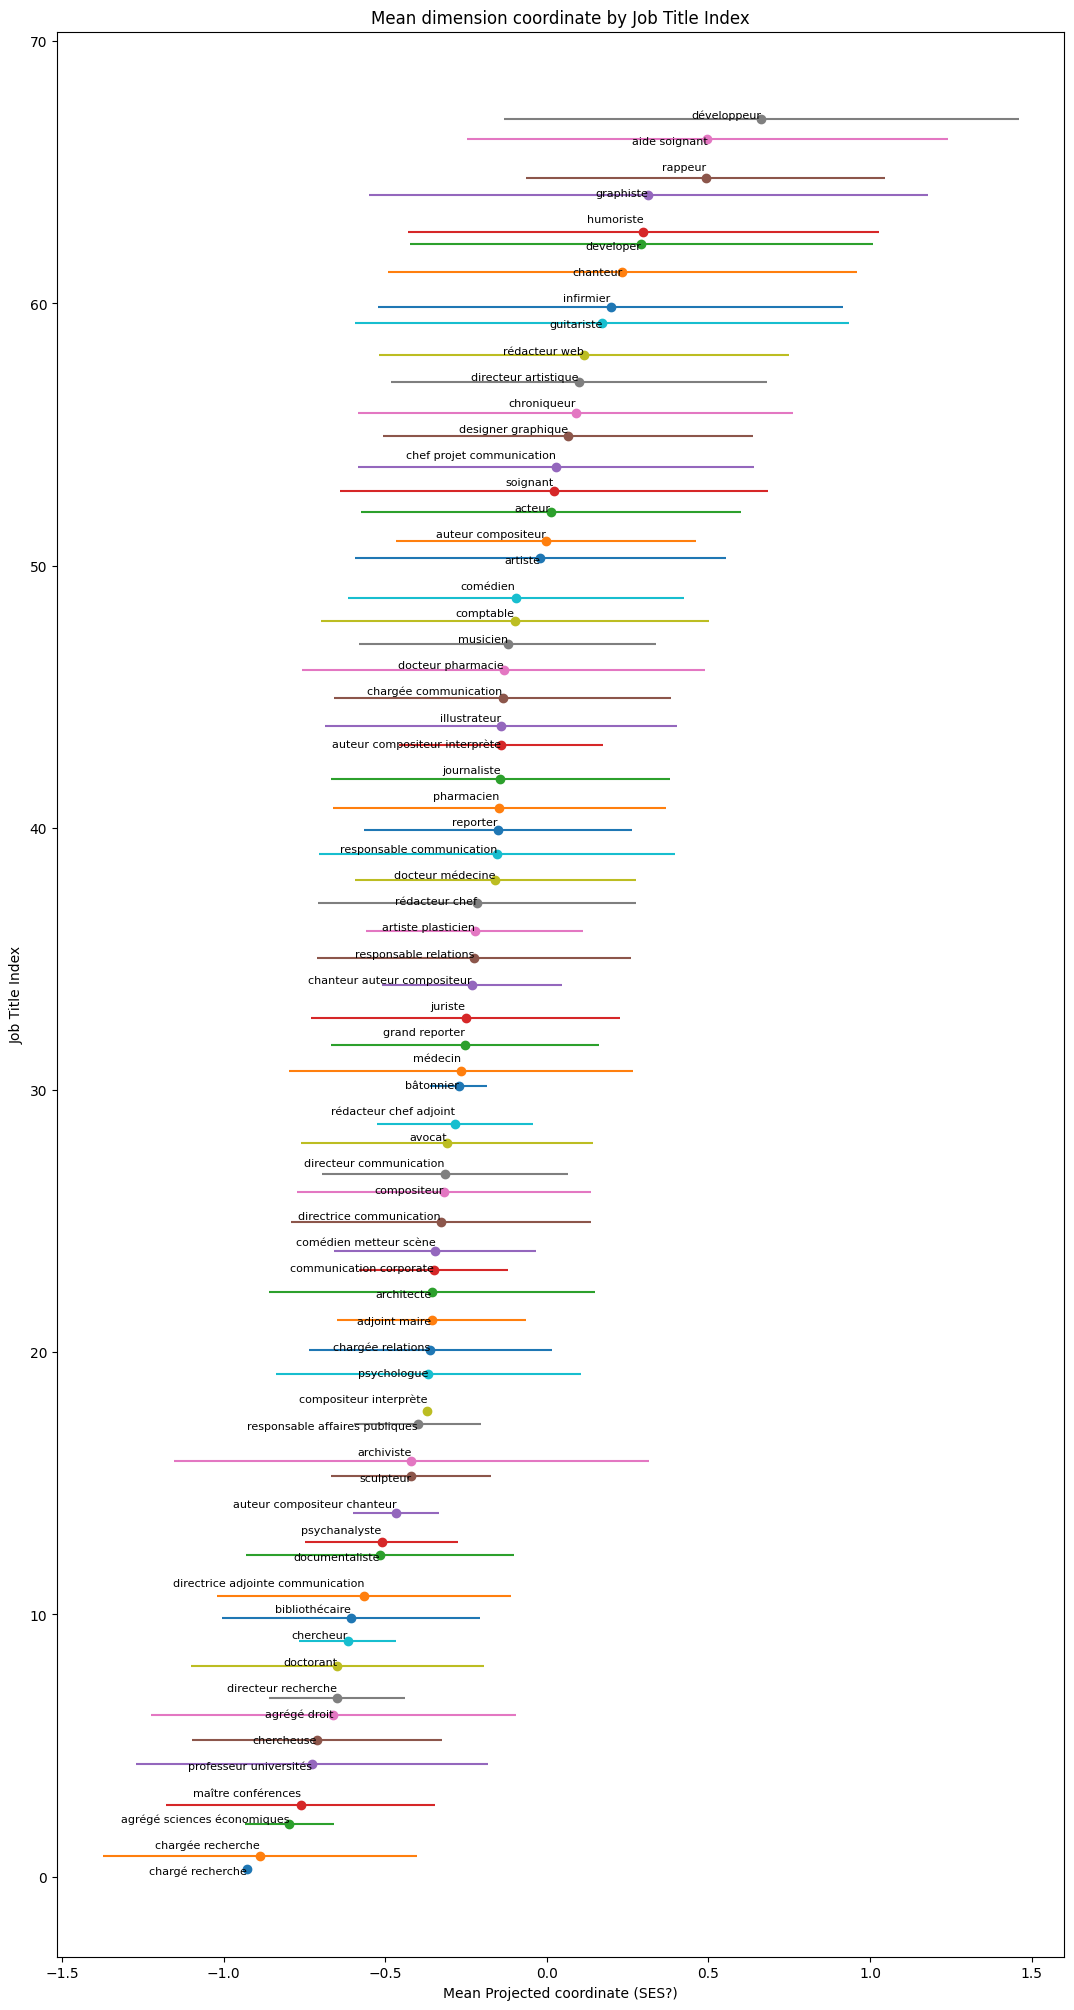

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = filtered.groupby('title').agg({'0': ['mean', 'std']}).reset_index()

# Sort the jobs by the mean SES and reset index
grouped = grouped.sort_values(('0', 'mean')).reset_index(drop=True)
plt.figure(figsize=(13, 25))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'mean')][i], 
                 y=i + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point with reduced text size
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'mean')][i], 
             i, 
             grouped['title'][i], 
             ha = 'right', va = 'bottom', fontsize=8)  # Adjust fontsize as needed

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Job Title Index')
plt.title('Mean dimension coordinate by Job Title Index')

plt.show()

In [127]:
onlygreens.head()

,follower_id,0,screen_name,key_word,description_cleantext,PCS_ESE,PCS_ESE_name,titles,label,Salaire moyen en EQTP
0,2866133451,1.401698,caudron_val59,acteur,Acteur Model photo Sports,354c,Artistes dramatiques,"('acteur',)",Artistes dramatiques,3700.0
1,1547965245007663106,1.342290,WllzFlorian,acteur,"Fan de politique, fan de télé, fan de sport.Devenir acteur est un rêve !",354c,Artistes dramatiques,"('acteur',)",Artistes dramatiques,3700.0
2,1392150937750450179,1.179636,CousinCyril5,acteur,Acteur film série clip rap Français web série ( Marsiglialaserie)pub https://www.allocine.fr/personne/fichepersonne_gen_cpersonne926083.html,354c,Artistes dramatiques,"('acteur',)",Artistes dramatiques,3700.0
3,197867866,0.570235,kliazid,acteur,Acteur / Comédien,354c,Artistes dramatiques,"('acteur',)",Artistes dramatiques,3700.0
4,187177090,0.472483,GregoryHoroszko,acteur,Acteur / Production audiovisuelle / French Actor / Audiovisual production.,354c,Artistes dramatiques,"('acteur',)",Artistes dramatiques,3700.0


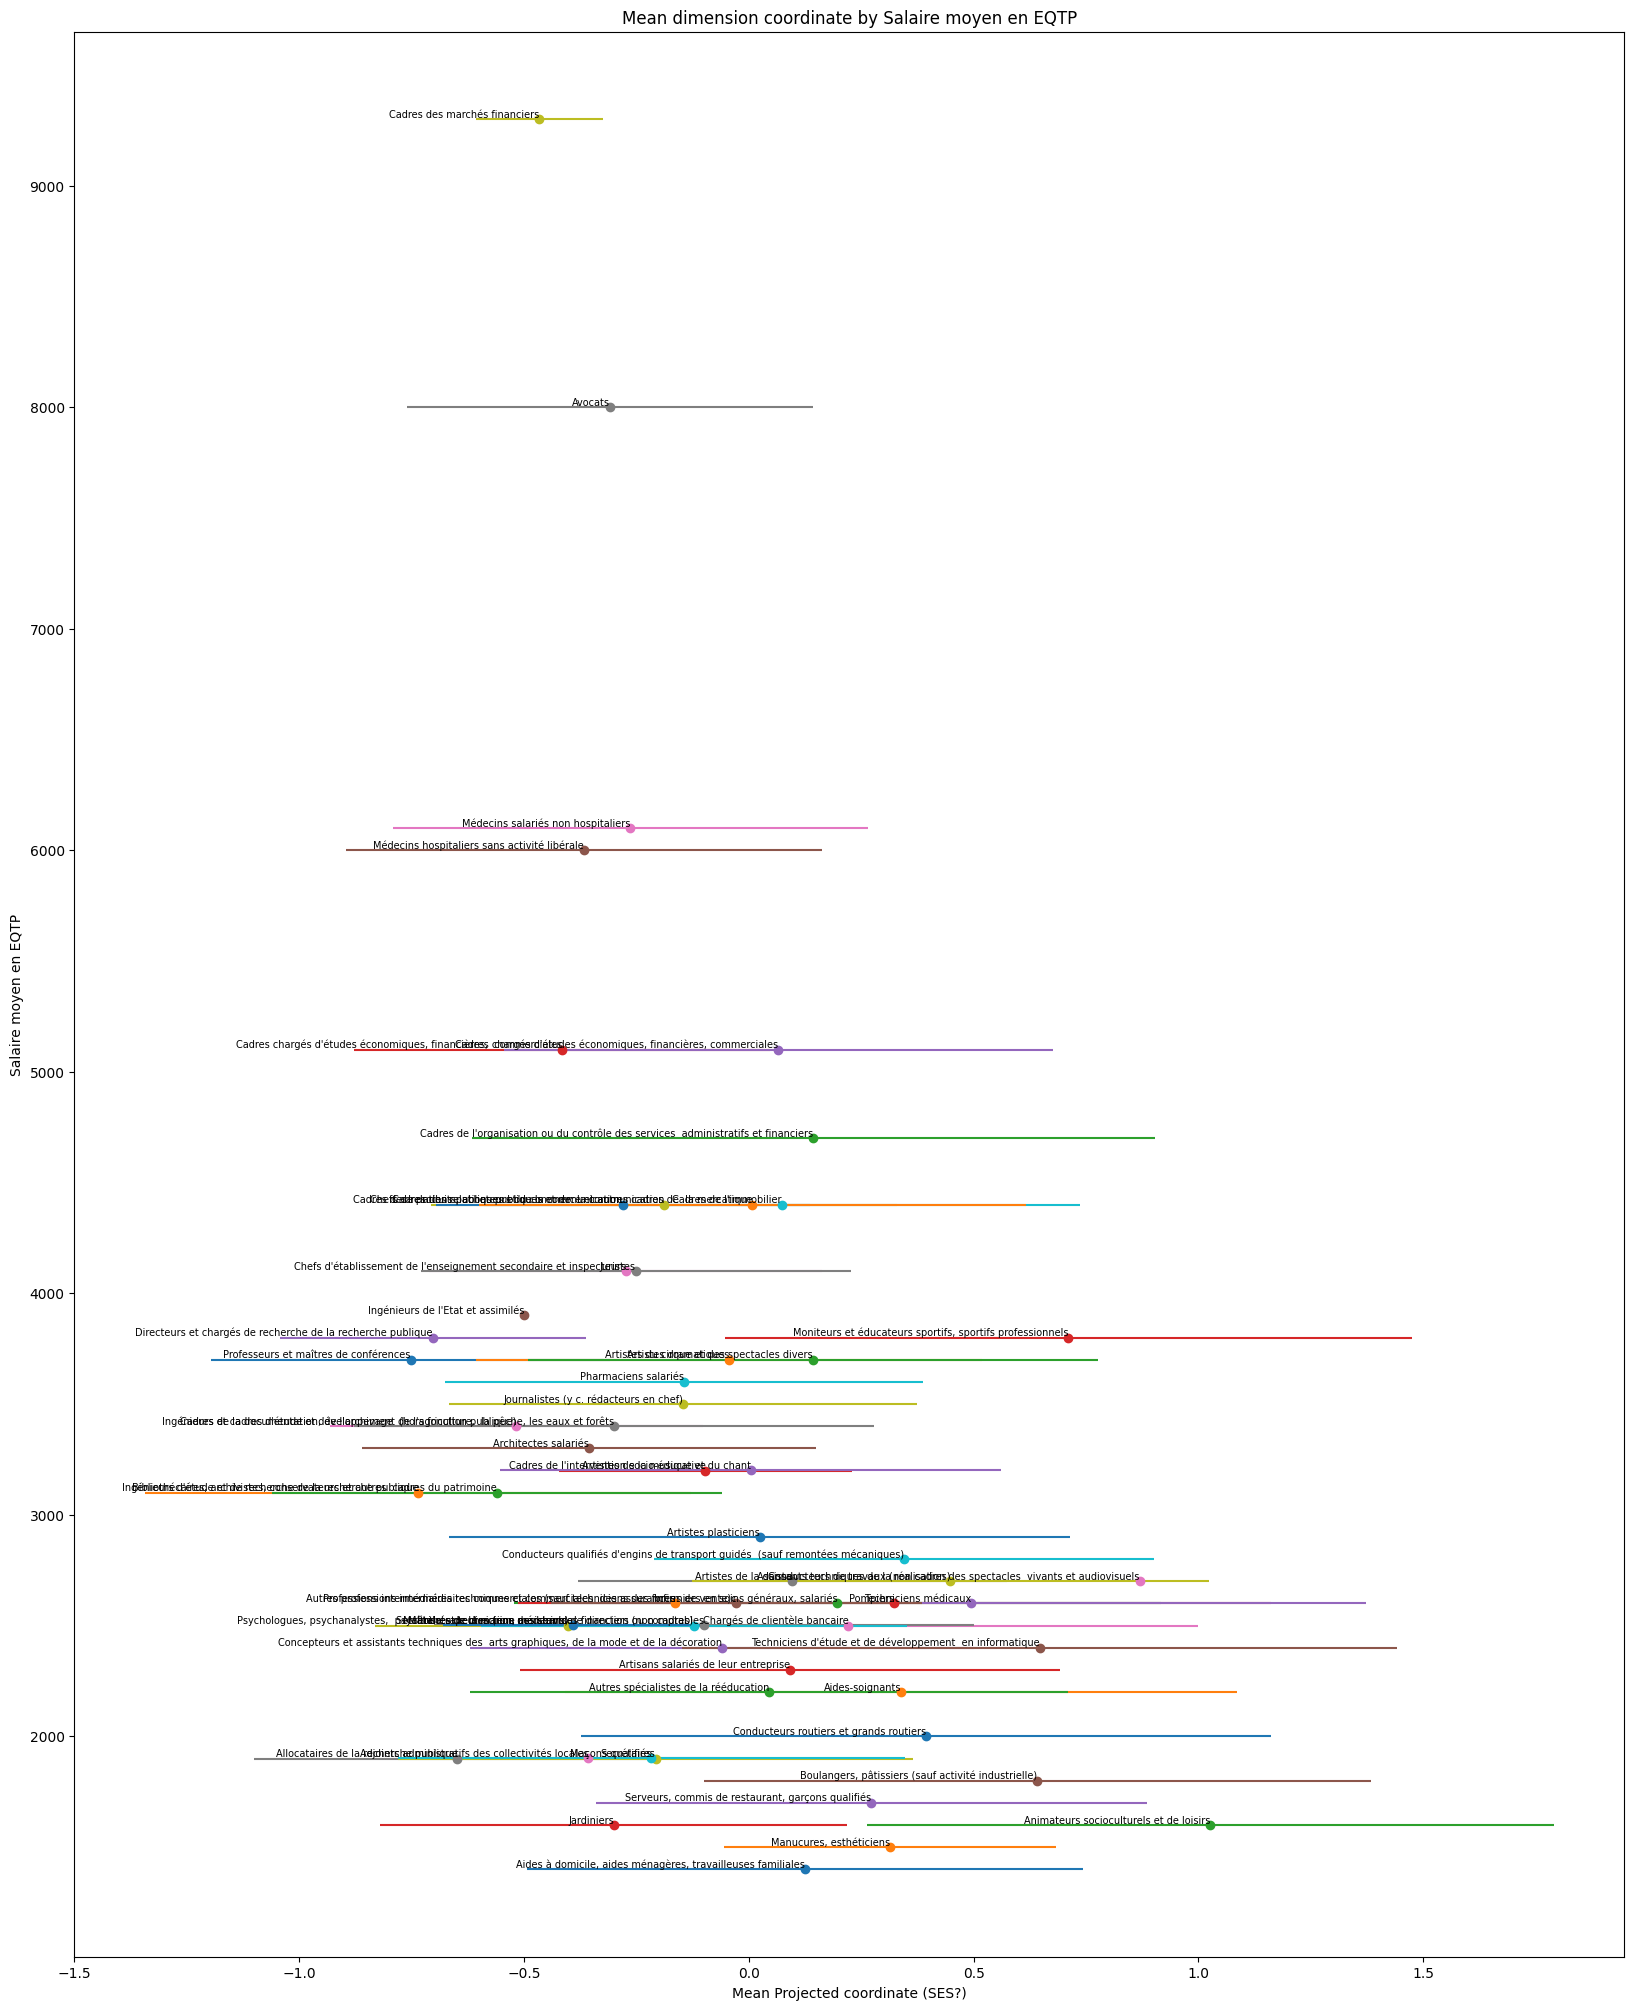

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of 'projection' and its standard deviation for each job group
grouped = onlygreens.groupby('PCS_ESE_name').agg({'0': ['mean', 'std'], 'Salaire moyen en EQTP': 'first'}).reset_index()

# Sort the jobs by 'Salaire moyen en EQTP' and reset index
grouped = grouped.sort_values(('Salaire moyen en EQTP', 'first')).reset_index(drop=True)
plt.figure(figsize=(20, 25))  # Adjust the size of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'mean')][i], 
                 y=grouped[('Salaire moyen en EQTP', 'first')][i] + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point with reduced text size
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'mean')][i], 
             grouped[('Salaire moyen en EQTP', 'first')][i], 
             grouped['PCS_ESE_name'][i], 
             ha = 'right', va = 'bottom', fontsize=7)  # Adjust fontsize as needed

plt.xlabel('Mean Projected coordinate (SES?)')
plt.ylabel('Salaire moyen en EQTP')
plt.title('Mean dimension coordinate by Salaire moyen en EQTP')

plt.show()

In [ ]:
x = bios_exploded[bios_exploded['PCS_ESE_name'] == 'Personnel administratif de catégorie A des collectivités locales et hôpitaux publics (hors Enseignement, Patrimoine)']
pd.set_option('display.max_colwidth', None)
x[['screen_name', 'projection', 'description_cleantext', 'titles','unigrams_detected', 'bigrams_detected', 'trigrams_detected']].iloc[0:12]

,screen_name,projection,description_cleantext,titles,unigrams_detected,bigrams_detected,trigrams_detected
9,melinjerome,-2.326592,"Conseiller Sportif dans le football, superviseur free-lance, passionné de foot et de sport...","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
17,FutureFootbal16,-2.322631,Agent de Joueurs de Football Gestion de Carrière Conseiller Sportif,"(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
20,soccer_antoine,-2.321397,"Conseiller Sportif. .................« No pain, no gain »","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
26,marinnicolas_16,-2.211545,"Ancien Joueur Professionnel de Football , aujourd’hui Conseiller Sportif","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
44,Kevin_Konrad11,-2.127862,Conseiller Sportif. Passionné de foot (Amiens SC / PSG).,"(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
99,Peyretben,-2.072327,"@AGMS, conseiller sportif, communication, marketing","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
277,33NEOKORTEX,-1.838784,"Entrepreneur, conseiller sportif spécialisé dans le Football, mais pas que. Votre interprétation de mes tweets n'engage que vous.","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
415,MekhaldiHedi,-1.697272,"Team SGM sport ( with @govousidney ) conseiller sportif pour les footballeurs professionnels, spécialiste management, communication, marketing.","(conseiller, sportif)",[],"[(conseiller, sportif)]",[]
647,LoicLecoq7,-1.338474,Scout et conseiller sportif en Ile de France Specialiste N2-N3,"(conseiller, sportif)",[],"[(conseiller, sportif)]",[]


In [ ]:
grouped

token         0            \
                                            mean       std   
0                        aide domicile  0.045984  0.564159   
1                        esthéticienne  0.379110  0.431971   
2                          maquilleuse  0.503914  0.103847   
3                             manucure  0.227777  0.228423   
4                    animateur enfance  0.954342       NaN   
5                            jardinier -0.196924  0.739179   
6                    animateur sportif  1.522271  0.169433   
7               animateur périscolaire  0.889229  1.601160   
8                   animateur jeunesse  0.567077  1.104068   
9                               barman  0.221853  0.589261   
10                             barista  0.427430  0.239876   
11                             barmaid  0.031241  0.481758   
12                         hospitalier -0.363437  0.480145   
13                 secrétaire médicale  0.129054  0.877013   
14                secrétaire rédaction -0.348158  0.472354   
15                          doctorante -0.747178  0.396485   
16                      adjointe maire -0.382505  0.231577   
17                           doctorant -0.581969  0.480453   
18                       adjoint maire -0.320737  0.351368   
19                  conducteur routier  0.588199  0.617970   
20                             caviste -0.092210  0.548506   
21                           soignante -0.044751  0.715796   
22                     psychomotricien  0.363649  0.884222   
23                       orthophoniste -0.434525  0.333757   
24                      ergothérapeute -0.485552  0.199476   
25                          ostéopathe  0.218835  0.666949   
26                      aide soignante  0.673257  0.710571   
27                         diététicien  0.032984  0.574626   
28                            coiffeur  0.313386  0.245212   
29                            artisane -0.335682       NaN   
30                             artisan -0.045381  0.496101   
31                           boulanger  0.653722  0.866516   
32                           developer  0.288245  0.691125   
33                  designer graphique  0.119099  0.642008   
34                       programmateur -0.122659  0.378222   
35                          développer -0.415416  0.686262   
36                         développeur  0.499191  0.827928   
37                            styliste  0.400338  0.389480   
38                        illustrateur -0.130254  0.578585   
39                       illustratrice -0.284838  0.511933   
40                       psychanalyste -0.491701  0.230237   
41                         chef bureau -0.441572  0.455718   
42                         psychologue -0.326833  0.540512   
43                              marine -0.036873  0.589392   
44                  secrétaire fédéral -0.345312  0.291395   
45               conseiller commercial  0.855957  0.584998   
46                    chargé clientèle  0.063772  0.291193   
47                       cheffe bureau -0.507622  0.419397   
48                assistante direction -0.077510  0.487335   
49                conseiller clientèle  0.251160  0.513077   
50                 assistant direction  0.426104  0.765448   
51                         photographe  0.121221  0.664645   
52                             pompier  0.366098  0.734088   
53                        photographer  0.227445  0.524032   
54                           librairie -0.504990  0.353890   
55              technicien laboratoire  0.463926  1.041997   
56                          radiologue  0.077534  0.397530   
57                     agent assurance -0.163924       NaN   
58                             sapeur   1.365485  0.291639   
59                            danseuse  0.035111  0.523807   
60                  conducteur travaux  0.448633  0.575918   
61                             danseur  0.130579  0.592119   
62                              danser  0.218475  0.674979   
63 

In [ ]:
import numpy as np
import os
import matplotlib
import pandas as pd

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import importlib

import sys
# # Local application imports
# sys.path.insert(0, '../Utility files')
# import utils2
# from utils2 import *

In [ ]:
#Get the user bios - that later wil get added income
# # Load the data

path = '/home/livtollanes/NewData/coordinates/dim_X/'
file = '/m1_dimx_users_bios.csv'
df = pd.read_csv(path+file, index_col=0)

#Sort the df according to the first dimenion
df = df.sort_values(by='0', ascending=False)

In [ ]:
import pandas as pd



# Regex pattern to match URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Filter rows where the bio contains a URL
url_bios = df[df['description_cleantext'].str.contains(url_pattern, na=False, regex=True)]
linkedin_bios = url_bios[url_bios['description_cleantext'].str.contains('linkedin', na=False, case=False)]

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
linkedin_bios

,follower_id,0,1,2,projection,screen_name,description_cleantext
110707,2264208407,1.613579,0.617701,-0.058194,-1.562009,Perez_S7,Responsable de Rayon @Decathlon - Ex @SportfiveFR - @SportMarket_fr & @MontpelEvents - Passionné de #Sport #SportBusiness - https://www.linkedin.com/profile/view?id318716164
110960,3802549216,1.528221,0.516361,-0.574804,-1.590691,m_leperque,Product Owner @panorabanques Respo comm @LigueRecruteurs #AllForOne #NBAFan Cuisto amateur #i4emploi http://bit.ly/LinkedInMLep
103758,2287271485,1.404488,0.499619,1.199399,-1.100636,instaply_fr,Nous postons régulièrement sur https://www.linkedin.com/company/instaply
108431,2147655175,1.315352,0.455734,-0.510604,-1.371939,LeSportBiz,Actualités et coulisses Offres d'emploi sur Linkedin Podcast http://bit.ly/3LVYMnM contact@lesportbusiness.com ou message privé
101573,742354601333141504,1.165949,0.233438,0.696692,-0.983878,_AlexFreedom_,"Divertir, Lire & Découvrir. Pour le reste, Contact Pro' : - http://bit.ly/_Linkedin_ - http://bit.ly/_Viadéo_ #Web #SocialMedia"
99941,1093904072007135232,1.089360,0.296829,0.758326,-0.893455,Aliscom_75,Votre partenaire pour une distribution innovante. #distribution #tech #innovation Page LinkedIn pour suivre notre actualité : http://linkedin.com/company/aliscom
102162,18598350,1.074443,0.293168,0.099488,-1.016391,gillessimon,mes tweets n’engagent que moi http://linkedin.com/in/gillessimon
99251,2607438710,1.072686,0.227810,0.887238,-0.853272,yanisleroy,"Passionné d'informatique, des nouvelles technos... Ingénieur Systèmes et Réseaux - Rédacteur à @liveboxmag et @bboxmag - http://linkedin.com/in/yanis-leroy"
96604,732129238946615296,1.019957,0.180039,1.298923,-0.717990,ScreenbaseDOOH,Agence full #DOOH services. Vous voyez du potentiel dans le DOOH? ca tombe bien nous aussi ! #AdTech #MediaLinkedin : https://tinyurl.com/ya68t4p9
94441,1042358542022270976,0.896530,0.367838,1.179746,-0.614120,olivier_foll,"@sturian1, conseil, gestion de projets IT, digitalisation, organisation et performances#ITSM #ITIL #Prince2http://fr.linkedin.com/in/olivier-le-..."


In [ ]:
linkedin_bios.shape

(149, 7)

### Discarded code

In [ ]:
#code used in work to look for releant titles
# filtered_rows = m1_bios_sorted[m1_bios_sorted['total_n_grams'].apply(lambda x: ('educateur', 'jeunes') in x)]
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# print(filtered_rows.shape)
# filtered_rows[['0', 'screen_name', 'description_cleantext', 'total_n_grams']].iloc[0:20]